<a href="https://colab.research.google.com/github/MohakSinghania/Gender-and-Age/blob/main/Gender_and_Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT MODULES

##DESCRIPTION
**pandas (imported as pd)**: A powerful data manipulation library that provides data structures and functions for efficiently working with structured data.

**numpy (imported as np):** A fundamental package for scientific computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

**os:** A module that provides a way to interact with the operating system. It is used here to perform operations related to file paths and directories.

**matplotlib.pyplot (imported as plt):** A plotting library for creating visualizations in Python. It provides a MATLAB-like interface for generating various types of plots, charts, and graphs.

**seaborn (optional):** A data visualization library based on matplotlib. It provides a high-level interface for creating informative and visually appealing statistical graphics.

**warnings:** A module used for handling warning messages. In this code, warnings.filterwarnings('ignore') is used to ignore any warning messages that might arise during execution.

**tqdm.notebook:** A library for creating progress bars and monitoring the progress of iterations in loops. It provides a user-friendly and visually appealing way to track the progress of long-running tasks.

**tensorflow (imported as tf):** An open-source machine learning framework developed by Google. It provides a wide range of tools and libraries for building and training machine learning models.

**tensorflow.keras.preprocessing.image.load_img:** A function from the Keras API of TensorFlow that is used to load an image from a file.

**keras.models.Sequential:** A class from the Keras API that represents a linear stack of layers. It is used to build a sequential model for the neural network.

**keras.layers:** A module from the Keras API that provides various types of layers for building neural networks, such as convolutional layers, pooling layers, dense layers, etc.

**keras.models.Model:** A class from the Keras API that allows you to build more complex models by defining the connections between layers explicitly.

In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential,Model
from keras.layers import Dense , Conv2D , Dropout , Flatten , MaxPooling2D , Input

# MOUNTING IN GOOGLE DRIVE AND UNZIPPING THE DATASET

### We need to first download the dataset and then login to our google drive and add the zip file in the folder you want to access

In [40]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/CODECLAUSE/archive.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/CODECLAUSE/archive.zip
replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace UTKFace/100_0_0_20170112215240346.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [n]o
error:  invalid response [[n]o]
replace UTKFace/100_0_0_20170112215240346.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace UTKFace/100_1_0_20170110183726390.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# LOADING THE DATASET

## Loading

In [41]:
BASE_DIR = '/content/UTKFace'

In [42]:
# labels - age , gender , ethnicity
image_paths = []  # Image List
age_labels = []   # Age list
gender_labels = []  # Gender list

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR , filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

## Convert To Dataframe

In [43]:
df = pd.DataFrame()
df['image'],df['age'],df['gender'] = image_paths , age_labels , gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/21_0_1_20170113133205762.jpg....,21,0
1,/content/UTKFace/78_0_0_20170111222508641.jpg....,78,0
2,/content/UTKFace/27_1_3_20170104232751618.jpg....,27,1
3,/content/UTKFace/26_1_1_20170112211652677.jpg....,26,1
4,/content/UTKFace/35_1_3_20170109140914004.jpg....,35,1


## Creating Gender Dictionary

In [44]:
# map labels for gender
gender_dict = {0:'Male',1:'Female'}

## Exploratory Data Analysis

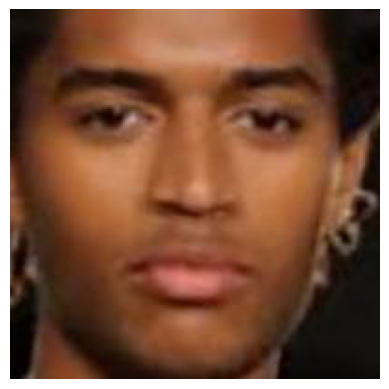

In [45]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

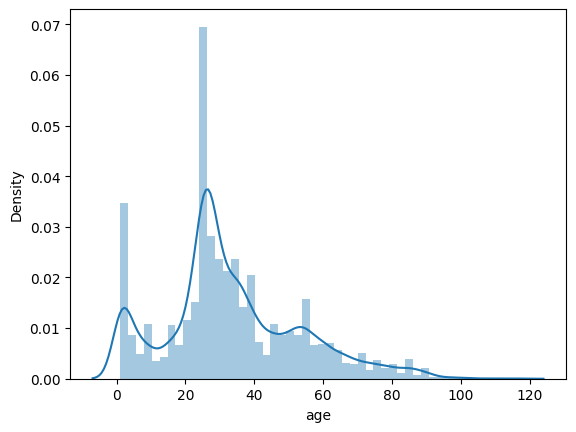

In [46]:
# Class Distribution
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

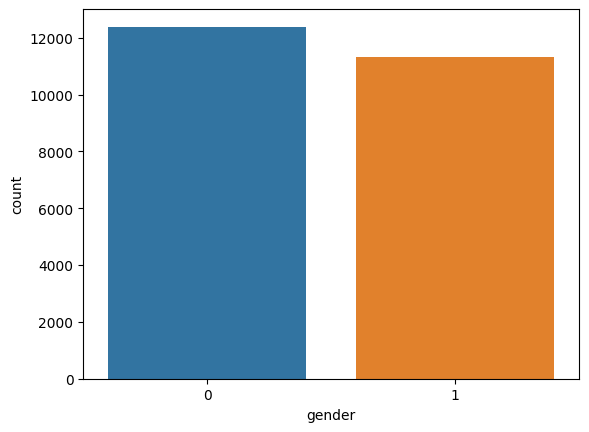

In [47]:
# Gender Distribution
sns.countplot(x='gender', data=df)

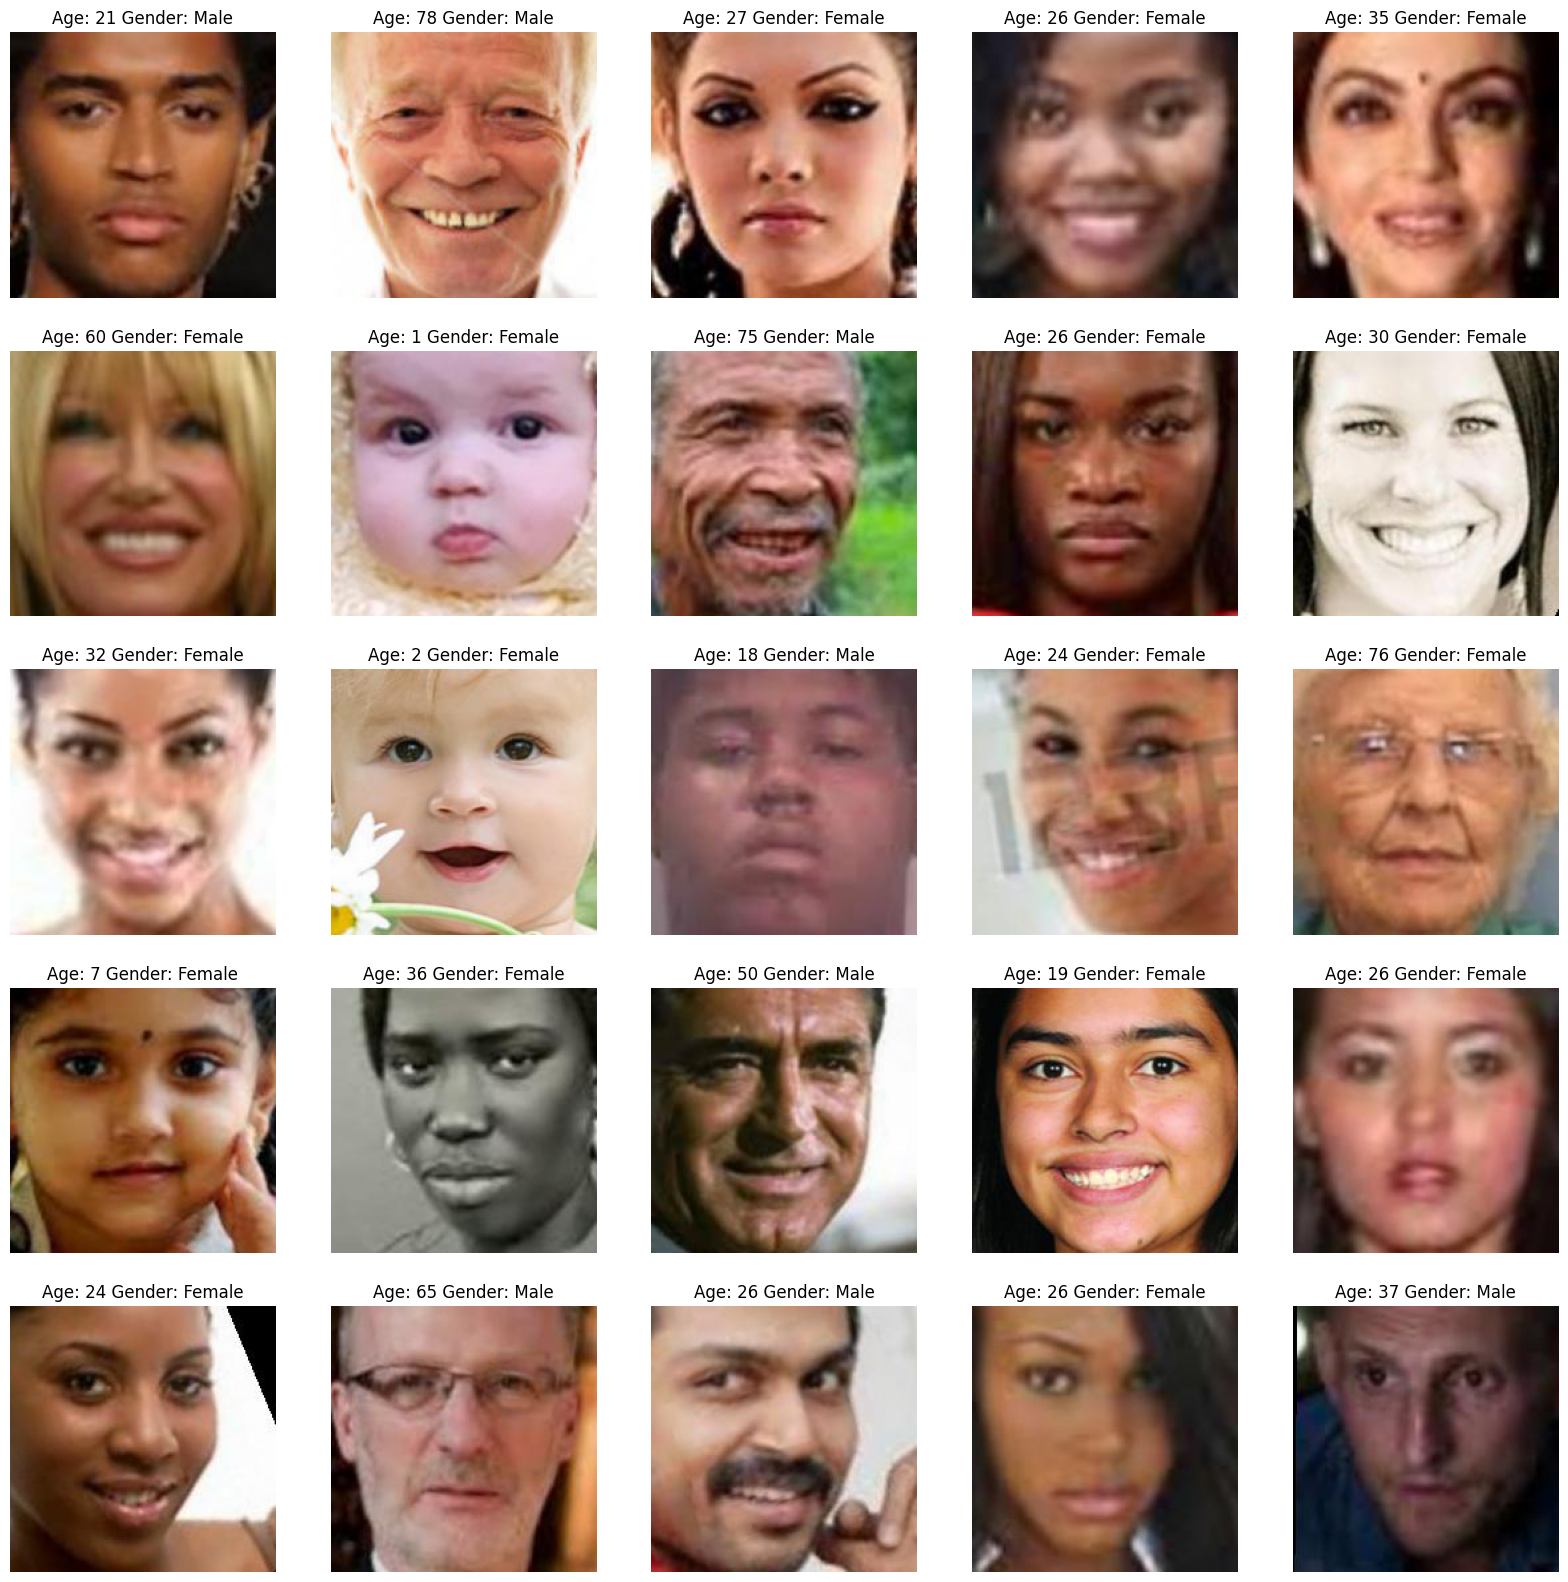

In [48]:
# Displaying Grid of Images
plt.figure(figsize=(20,20))
files = df.iloc[0:25]

for index , file , age , gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# FEATURE EXTRACTION

## Defining The Function

In [49]:
# Load in RGB will be in 3 dimensional so to avoid crashing we use Grayscale
# In reshape method , by default there is 3 which represent RGB , but we use 1 which represent Grayscale
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = img.resize((128,128),Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features),128,128,1)
    return features

In [50]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [51]:
# Checking the shape of Data
X.shape

(23708, 128, 128, 1)

In [52]:
# Normalizing the images because pixel range varies from 0 to 255
X = X/255.0

## Converting to NumPy Array

In [53]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

## Configuration

In [54]:
input_shape = (128 , 128 , 1)

# MODEL CREATION

## This is CNN(Convolution Neural Network) , we are using images as input and we get two output i.e. one for classification and another for regression , so we need to specify two loss matrix

In [55]:
# ReLu improves model performance so we use ReLu function
inputs = Input((input_shape))

# Convolution Layers
conv_1 = Conv2D(32 , kernel_size = (3,3) , activation = 'relu')(inputs)
maxp_1 = MaxPooling2D(pool_size = (2,2))(conv_1)
conv_2 = Conv2D(64 , kernel_size = (3,3) , activation = 'relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size = (2,2))(conv_2)
conv_3 = Conv2D(128 , kernel_size = (3,3) , activation = 'relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size = (2,2))(conv_3)
conv_4 = Conv2D(256 , kernel_size = (3,3) , activation = 'relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size = (2,2))(conv_4)

# Flatten converts to single layer vectors
flatten = Flatten()(maxp_4)

# Fully Connected Layers
dense_1 = Dense(256,activation = 'relu')(flatten)
dense_2 = Dense(256,activation = 'relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1,activation = 'sigmoid' , name='gender_out')(dropout_1)
output_2 = Dense(1,activation = 'relu' , name='age_out')(dropout_2)

# Compiling to Single model
model = Model(inputs = [inputs] , outputs = [output_1,output_2])

# binary_crossentropy - Binary Classification
# mae : mean absolute error - Regression
model.compile(loss = ['binary_crossentropy', 'mae'] , optimizer = 'adam' , metrics = ['accuracy'])

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

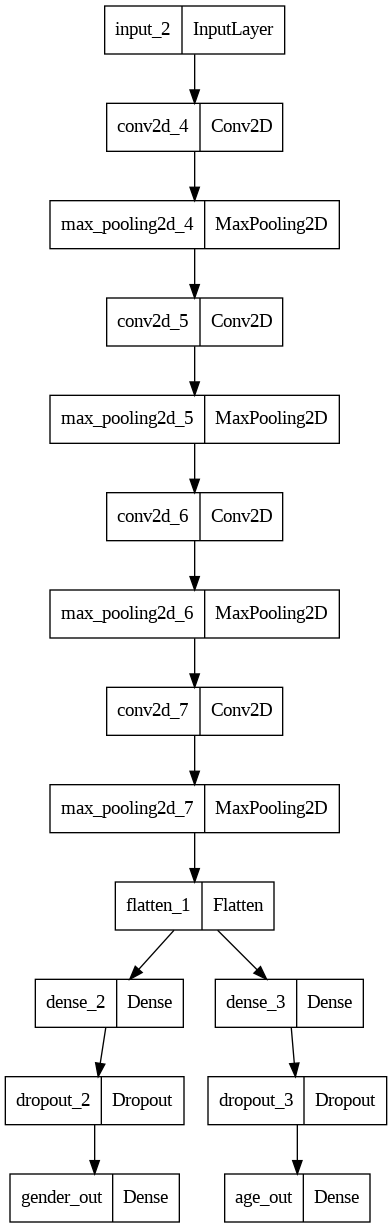

In [57]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

# TRAIN MODEL

In [58]:
history = model.fit(x=X , y=[y_gender,y_age] , batch_size =32 , epochs = 30 , validation_split=0.2)


Epoch 1/30
593/593 [==============================] - 17s 21ms/step - loss: 15.9371 - gender_out_loss: 0.6915 - age_out_loss: 15.2455 - gender_out_accuracy: 0.5481 - age_out_accuracy: 0.0479 - val_loss: 13.1341 - val_gender_out_loss: 0.5542 - val_age_out_loss: 12.5798 - val_gender_out_accuracy: 0.7233 - val_age_out_accuracy: 0.0434
Epoch 2/30
593/593 [==============================] - 12s 19ms/step - loss: 11.6272 - gender_out_loss: 0.4967 - age_out_loss: 11.1305 - gender_out_accuracy: 0.7640 - age_out_accuracy: 0.0294 - val_loss: 10.3870 - val_gender_out_loss: 0.4060 - val_age_out_loss: 9.9810 - val_gender_out_accuracy: 0.8092 - val_age_out_accuracy: 0.0160
Epoch 3/30
593/593 [==============================] - 12s 20ms/step - loss: 9.7901 - gender_out_loss: 0.3995 - age_out_loss: 9.3906 - gender_out_accuracy: 0.8155 - age_out_accuracy: 0.0156 - val_loss: 8.9955 - val_gender_out_loss: 0.3483 - val_age_out_loss: 8.6472 - val_gender_out_accuracy: 0.8420 - val_age_out_accuracy: 0.0127
Epo

## Plot the Results

### For Gender

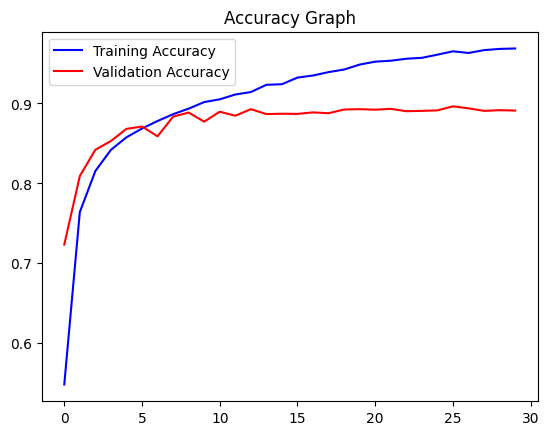

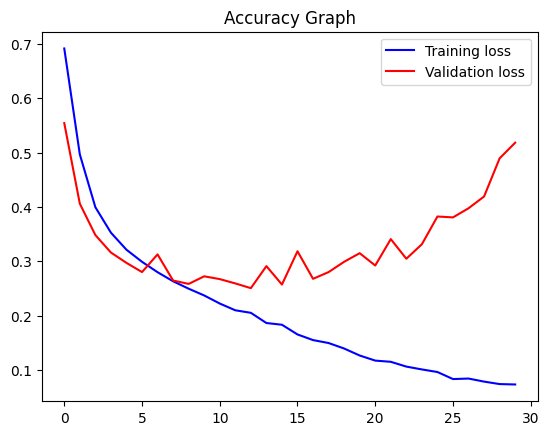

In [59]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs , acc , 'b' , label='Training Accuracy')
plt.plot(epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs , loss , 'b' , label='Training loss')
plt.plot(epochs , val_loss , 'r' , label = 'Validation loss')
plt.title('Accuracy Graph')
plt.legend()
plt.show()



### For Age

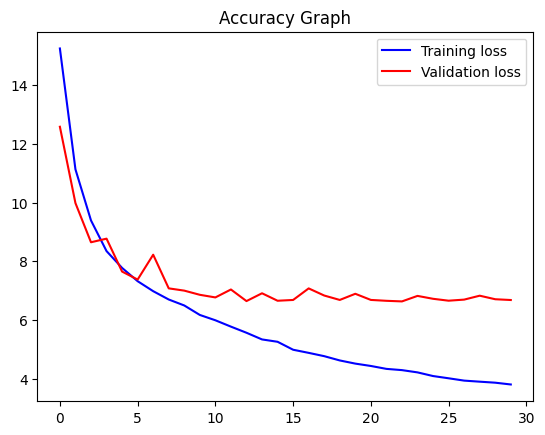

In [60]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs , loss , 'b' , label='Training loss')
plt.plot(epochs , val_loss , 'r' , label = 'Validation loss')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

# PREDICTION WITH TEST DATA

Original Gender: Female Original Age: 18
1/1 [==============================] - 0s 136ms/step
Predicted Gender: Female Predicted Age: 18


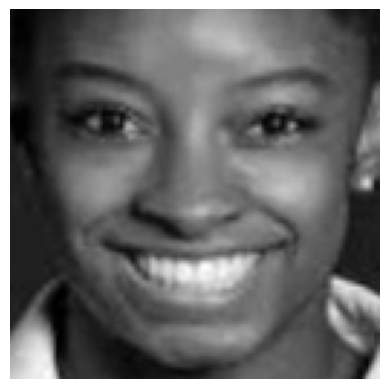

In [61]:
image_index = 200
print('Original Gender:',gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Male Original Age: 29
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male Predicted Age: 31


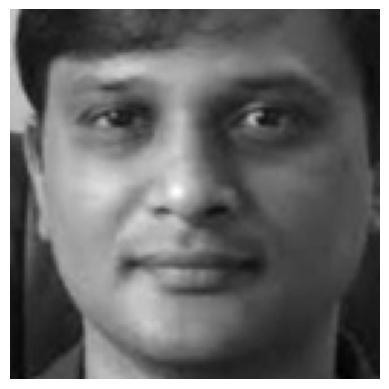

In [62]:
image_index = 3000
print('Original Gender:',gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Female Original Age: 7
1/1 [==============================] - 0s 28ms/step
Predicted Gender: Female Predicted Age: 10


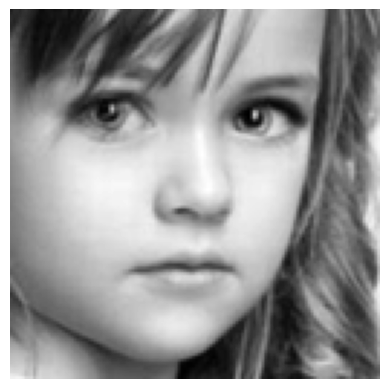

In [63]:
image_index = 10000
print('Original Gender:',gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Male Original Age: 30
1/1 [==============================] - 0s 28ms/step
Predicted Gender: Male Predicted Age: 33


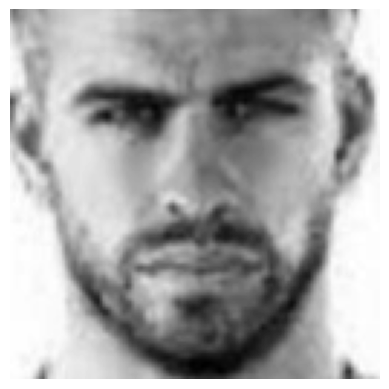

In [64]:
image_index = 100
print('Original Gender:',gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray');